# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [4]:
# import libraries
import datetime
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,min,max,avg


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



In [5]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


In [6]:
#load the data
path = "mini_sparkify_event_data.json"
data = spark.read.json(path)

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [7]:
data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
#check the counts
data.count()

286500

In [9]:
#check the number that session ID is not empty 
data.filter(data.sessionId == "" ).count()

0

In [10]:
#check the number that userID is not empty 
data.filter(data.userId == "" ).count()

8346

In [11]:
#Delete the line that there is no userID
data.dropna(how = "any",subset=["sessionId","userId"] )
data.count()

286500

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [12]:
#check the column
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
#check how many values inside page column
data.select("page").drop_duplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [14]:
#check how many users did the confirmed cancellation
data.filter(data.page=="Cancellation Confirmation").select("userId").dropDuplicates().count()

52

In [15]:
# transform the time format and add a time column
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
data = data.withColumn("time", get_time(data.ts))

In [16]:
#check the time column
data.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|               time|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 08:01:57|
|    Five Ir

In [17]:
#Create Churn column, ture means user did Cancellation Confirmation, otherwise it is false
cc_users = data.filter(data.page=="Cancellation Confirmation").select("userId").dropDuplicates()
cc_users_list = [(row['userId']) for row in cc_users.collect()]
data_withchurn = data.withColumn("churn", data.userId.isin(cc_users_list))

In [18]:
#Check the value of churn column
data_withchurn.select(["userId","churn"]).where(data.userId == "125").show()

+------+-----+
|userId|churn|
+------+-----+
|   125| true|
|   125| true|
|   125| true|
|   125| true|
|   125| true|
|   125| true|
|   125| true|
|   125| true|
|   125| true|
|   125| true|
|   125| true|
+------+-----+



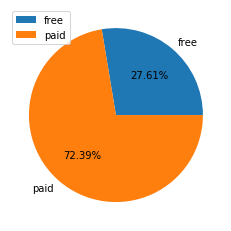

In [19]:
#analysis the churn by the level
data_level = data_withchurn.filter(data_withchurn.churn == "true").select(["level","churn"]).groupby("level").count()
data_level = data_level.toPandas()
data_level.head()

plt.pie(x = list(data_level["count"]),labels=list(data_level["level"]),autopct="%0.2f%%")
plt.legend()
plt.show() 

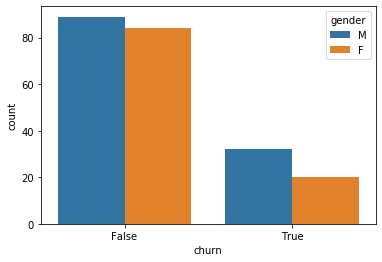

In [20]:
#analysis the churn by the gender 
data_gendor = data_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=data_gendor)

In [21]:
#analysis the churn by time and date, analysis the data and add 3 columns

hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
data_withchurn = data_withchurn.withColumn("hour", hour(data_withchurn.ts))

weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
data_withchurn = data_withchurn.withColumn("weekday", weekday(data_withchurn.ts))

day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
data_withchurn = data_withchurn.withColumn("day", day(data_withchurn.ts))

In [22]:
#check the transferred time column
data_withchurn.select(["userId","hour","weekday","day"]).show(5)

+------+----+-------+---+
|userId|hour|weekday|day|
+------+----+-------+---+
|    30|   8|      1|  1|
|     9|   8|      1|  1|
|    30|   8|      1|  1|
|     9|   8|      1|  1|
|    30|   8|      1|  1|
+------+----+-------+---+
only showing top 5 rows



In [23]:
def get_plot_date_page_churn(date,page,churn,color,label):
    '''
    Define a function to show the plt for date/page/churn
    '''
    data_pd = data_withchurn.filter(data_withchurn.page == page).groupby("churn", date).count().orderBy(data_withchurn[date].cast("float")).toPandas()
    data_pd[data_pd.churn == churn].plot.bar(x = date, y = 'count', color= color, label= label)
    plt.show()

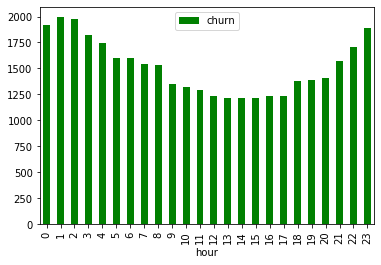

In [24]:
get_plot_date_page_churn("hour","NextSong",True,"Green","churn")

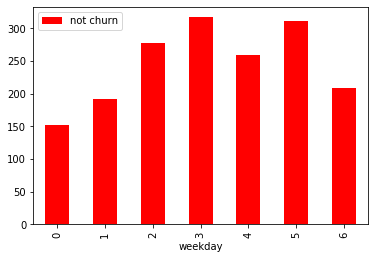

In [25]:
get_plot_date_page_churn("weekday","Downgrade",False,"red","not churn")

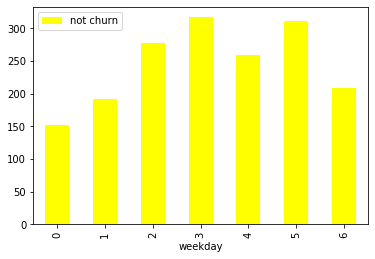

In [26]:
get_plot_date_page_churn("weekday","Downgrade",False,"yellow","not churn")

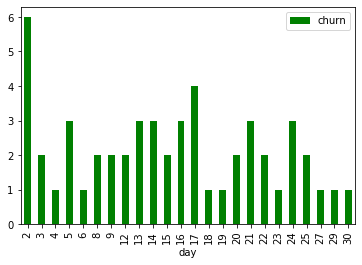

In [27]:
get_plot_date_page_churn("day","Cancellation Confirmation",True,"green","churn")

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [28]:
#features 1: get user regestion days
user_max_ts = data_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = data_withchurn.select(
    "userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(
    user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(
        user_reg_ts["userId"],
        ((user_max_ts["max(ts)"] - user_reg_ts["registration"]) /
         (1000 * 60 * 60 * 24)).alias("regDays"))

user_reg_days.show(10)

+------+------------------+
|userId|           regDays|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
|     7| 72.77818287037037|
|    15|56.513576388888886|
|    54|110.75168981481481|
|   155|23.556018518518517|
|100014| 85.08340277777778|
+------+------------------+
only showing top 10 rows



In [29]:
#features 2 If user is a paid user or free user
#get the user paid /free status with the maximum timestramp 
user_pf_status = data_withchurn.groupby("userId", "level").agg(max(data_withchurn.ts).alias("lastTime")).sort("userId")
#get the user's latest timestramp 
user_lastest_level_time = user_pf_status.groupby("userId").agg(max(user_pf_status.lastTime).alias("lastest"))
#Join the 2 tables
temp = user_pf_status.join(user_lastest_level_time,[user_pf_status.userId == user_lastest_level_time.userId, user_lastest_level_time.lastest == user_pf_status.lastTime]).select(user_pf_status.userId,user_pf_status.level)
#transfer the data, free is 0, paid is 1
user_level = temp.replace(["free", "paid"], ["0", "1"], "level")
user_level = user_level.withColumnRenamed("userId", "user_level_id")
user_level.show(10)

+-------------+-----+
|user_level_id|level|
+-------------+-----+
|       200008|    1|
|           96|    1|
|       200002|    1|
|           49|    1|
|           68|    0|
|           47|    0|
|       200025|    1|
|       300006|    1|
|       100007|    1|
|           11|    1|
+-------------+-----+
only showing top 10 rows



In [30]:
#Features 3 User's gender 
user_gender = data_withchurn.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", "gender")
user_gender = user_gender.withColumnRenamed("userId", "user_gender_id")
user_gender.show(5)


+--------------+------+
|user_gender_id|gender|
+--------------+------+
|            44|     1|
|            46|     1|
|            41|     1|
|            72|     1|
|        300023|     1|
+--------------+------+
only showing top 5 rows



In [31]:
#Features 4 How many songs user has been interacted

user_song_interact = data_withchurn.select("userId","song").drop_duplicates().groupby("userId").count()
user_song_interact = user_song_interact.withColumnRenamed("userId", "user_song_interact_id")
user_song_interact.show(5)


+---------------------+-----+
|user_song_interact_id|count|
+---------------------+-----+
|               100010|  270|
|               200002|  379|
|                  125|    9|
|                   51| 1855|
|                  124| 3340|
+---------------------+-----+
only showing top 5 rows



In [32]:
#Feature 5: how many singers has the user heard
user_artist_count = data_withchurn.filter(data_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")
user_artist_count = user_artist_count.withColumnRenamed("userId", "user_artist_count_id")
user_artist_count.show(5)

+--------------------+-----------+
|user_artist_count_id|aritstCount|
+--------------------+-----------+
|              100010|        252|
|              200002|        339|
|                 125|          8|
|                  51|       1385|
|                 124|       2232|
+--------------------+-----------+
only showing top 5 rows



In [33]:
#feature 6 time indicator per user
user_session_time = data_withchurn.groupby("userId", "sessionId").agg(((max(data_withchurn.ts)-min(data_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("SessionavgTime"), min(user_session_time.sessionTime).alias("SessionminTime"), max(user_session_time.sessionTime).alias("SessionmaxTime")).sort("userId")
user_session_time_stat = user_session_time_stat.withColumnRenamed("userId", "user_session_time_stat_id")
user_session_time_stat.show(10)

+-------------------------+------------------+-----------------+------------------+
|user_session_time_stat_id|    SessionavgTime|   SessionminTime|    SessionmaxTime|
+-------------------------+------------------+-----------------+------------------+
|                         | 5838.938684264373|              0.0|          84056.45|
|                       10|459.74722222222226|91.41666666666667|1547.9166666666667|
|                      100| 316.5190476190476|              0.0|1019.5833333333334|
|                   100001|148.15833333333333|             63.0|215.28333333333333|
|                   100002|201.18333333333334|              0.0| 730.4666666666667|
|                   100003| 99.11666666666667|3.216666666666667|195.01666666666668|
|                   100004|185.98650793650793|              0.0| 940.2166666666667|
|                   100005|120.18666666666668|              0.0|209.21666666666667|
|                   100006| 93.43333333333334|93.43333333333334| 93.43333333

In [34]:
#Features 7 get number of the songs for each session
user_session_songs_count = data_withchurn.filter(data_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs_count.groupby("userId").agg(avg("count").alias("avgSessionSongs")).sort("userId")
user_session_songs_avg = user_session_songs_avg.withColumnRenamed("userId", "user_session_songs_avg_id")
user_session_songs_avg.show(5)

+-------------------------+------------------+
|user_session_songs_avg_id|   avgSessionSongs|
+-------------------------+------------------+
|                       10|112.16666666666667|
|                      100| 78.88235294117646|
|                   100001|             33.25|
|                   100002|             48.75|
|                   100003|              25.5|
+-------------------------+------------------+
only showing top 5 rows



In [35]:
#Combine all the features to user_data dataframe
user_data = user_reg_days.join(user_level,user_reg_days.userId == user_level.user_level_id).drop("user_level_id")
user_data = user_data.join(user_gender,user_data.userId == user_gender.user_gender_id).drop("user_gender_id")
user_data = user_data.join(user_song_interact,user_data.userId == user_song_interact.user_song_interact_id).drop("user_song_interact_id")
user_data = user_data.join(user_artist_count,user_data.userId == user_artist_count.user_artist_count_id).drop("user_artist_count_id")
user_data = user_data.join(user_session_time_stat,user_data.userId == user_session_time_stat.user_session_time_stat_id).drop("user_session_time_stat_id")
user_data = user_data.join(user_session_songs_avg,user_data.userId == user_session_songs_avg.user_session_songs_avg_id).drop("user_session_songs_avg_id")

user_data.show(5)


+------+------------------+-----+------+-----+-----------+------------------+------------------+------------------+------------------+
|userId|           regDays|level|gender|count|aritstCount|    SessionavgTime|    SessionminTime|    SessionmaxTime|   avgSessionSongs|
+------+------------------+-----+------+-----+-----------+------------------+------------------+------------------+------------------+
|100010| 55.64365740740741|    0|     1|  270|        252|154.48333333333332|             22.55|             323.0|39.285714285714285|
|200002| 70.07462962962963|    1|     0|  379|        339|266.40000000000003|              12.1|            497.45|              64.5|
|   125| 71.31688657407408|    0|     0|    9|          8|29.566666666666666|29.566666666666666|29.566666666666666|               8.0|
|   124|131.55591435185184|    1|     1| 3340|       2232| 578.9942528735633|               0.0|1770.6166666666666|145.67857142857142|
|    51|19.455844907407407|    1|     0| 1855|       13

In [36]:
#get user's lable data
user_label = data_withchurn.select("userId", "churn").dropDuplicates()
user_label = user_label.select("userId", user_label.churn.cast("int"))
user_label = user_label.withColumnRenamed("userId", "user_label_id")
user_label.show(5)

+-------------+-----+
|user_label_id|churn|
+-------------+-----+
|           19|    0|
|       100005|    1|
|       200007|    0|
|       300007|    1|
|           50|    0|
+-------------+-----+
only showing top 5 rows



In [37]:
#Combine Features and Labels Together
user_data_final = user_data.join(user_label,user_data.userId == user_label.user_label_id).drop("user_label_id")

In [38]:
#Show final data
user_data_final.show(5)

+------+------------------+-----+------+-----+-----------+------------------+------------------+------------------+------------------+-----+
|userId|           regDays|level|gender|count|aritstCount|    SessionavgTime|    SessionminTime|    SessionmaxTime|   avgSessionSongs|churn|
+------+------------------+-----+------+-----+-----------+------------------+------------------+------------------+------------------+-----+
|100010| 55.64365740740741|    0|     1|  270|        252|154.48333333333332|             22.55|             323.0|39.285714285714285|    0|
|200002| 70.07462962962963|    1|     0|  379|        339|266.40000000000003|              12.1|            497.45|              64.5|    0|
|   125| 71.31688657407408|    0|     0|    9|          8|29.566666666666666|29.566666666666666|29.566666666666666|               8.0|    1|
|   124|131.55591435185184|    1|     1| 3340|       2232| 578.9942528735633|               0.0|1770.6166666666666|145.67857142857142|    0|
|    51|19.45

In [39]:
#Save the data into CSV File
path = "user_data_final.csv"
user_data_final.toPandas().to_csv(path)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [40]:
user_data_final = spark.read.csv(path, header=True)
user_data_final.persist()

DataFrame[_c0: string, userId: string, regDays: string, level: string, gender: string, count: string, aritstCount: string, SessionavgTime: string, SessionminTime: string, SessionmaxTime: string, avgSessionSongs: string, churn: string]

In [41]:
#Transfer all the features to numeric
for col in user_data_final.columns[1:]:
    col_name = col + "Num"
    user_data_final = user_data_final.withColumn(col_name, user_data_final[col].cast("float"))
    user_data_final = user_data_final.drop(col)



In [42]:
user_data_final.show(5)

+---+---------+----------+--------+---------+--------+--------------+-----------------+-----------------+-----------------+------------------+--------+
|_c0|userIdNum|regDaysNum|levelNum|genderNum|countNum|aritstCountNum|SessionavgTimeNum|SessionminTimeNum|SessionmaxTimeNum|avgSessionSongsNum|churnNum|
+---+---------+----------+--------+---------+--------+--------------+-----------------+-----------------+-----------------+------------------+--------+
|  0| 100010.0| 55.643658|     0.0|      1.0|   270.0|         252.0|        154.48334|            22.55|            323.0|         39.285713|     0.0|
|  1| 200002.0|  70.07463|     1.0|      0.0|   379.0|         339.0|            266.4|             12.1|           497.45|              64.5|     0.0|
|  2|    125.0|  71.31689|     0.0|      0.0|     9.0|           8.0|        29.566668|        29.566668|        29.566668|               8.0|     1.0|
|  3|    124.0| 131.55591|     1.0|      1.0|  3340.0|        2232.0|        578.99426| 

In [45]:
t = user_data_final.count()
print(t)

225


In [46]:
# put the features into vector
assembler = VectorAssembler(inputCols=user_data_final.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(user_data_final)

scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))

#Split the data into train set and validation set
train, validation = data.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [48]:
#using LR model
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [49]:
#Train the model
Model_lr = crossval.fit(train)
Model_lr.avgMetrics

[0.7385121894409736,
 0.7083480420436586,
 0.6990333787359971,
 0.7385121894409736,
 0.7113078833414272,
 0.6990333787359971,
 0.7385121894409736,
 0.6990333787359971,
 0.6791973265715276,
 0.7385121894409736,
 0.6767639014108298,
 0.6791973265715276]

In [51]:
#user gbt model
gbt  = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6, 8]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)


In [52]:
#Train the model
Model_gbt = crossval_gbt.fit(train)
Model_gbt.avgMetrics

[0.7893814955939045,
 0.731928853564967,
 0.6961925606283896,
 0.703681211578949,
 0.7798820703649191,
 0.7271958935412806,
 0.6961925606283896,
 0.703681211578949,
 0.7837826836405324,
 0.7196501278151243,
 0.6930091005445191,
 0.6967975087354431]

In [54]:
#Use Decision Tree Model
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [55]:
#Train the model
Model_dt = crossval_dt.fit(train)
Model_dt.avgMetrics


[0.778510797664383,
 0.7661508602194741,
 0.7449597559273801,
 0.7221001744814494,
 0.7118411316078894,
 0.6879222577794387,
 0.6932731763522308,
 0.7893814955939045,
 0.758766498154155,
 0.7369243849162306,
 0.7030445412376388,
 0.7015413493811862,
 0.6967975087354431,
 0.703681211578949]

In [56]:
#define a fucntion to calculate F1 Score
def getF1(Model,validation):
    prediction = Model.transform(validation)
    r = prediction.filter("label = 1 and prediction = 1").count()
    e = prediction.filter("label = 0 and prediction = 1").count()
    p = prediction.filter("label = 1 and prediction = 0").count()
    precision = r / (r + e) 
    recall = r / (r + p)
    f1 = 2*precision*recall / (precision+recall)
    result = []
    result.append(precision)
    result.append(recall)
    result.append(f1)
    return result

In [60]:
#test the reulst for LR model
result=[]
result = getF1(Model_lr,validation)
print("precision is {}".format(result[0]))
print("recall is {}".format(result[1]))
print("F1 Score is {}".format(result[2]))

precision is 1.0
recall is 0.1111111111111111
F1 Score is 0.19999999999999998


In [61]:
#test the reulst for gbt model
result=[]
result = getF1(Model_gbt,validation)
print("precision is {}".format(result[0]))
print("recall is {}".format(result[1]))
print("F1 Score is {}".format(result[2]))

precision is 0.5714285714285714
recall is 0.4444444444444444
F1 Score is 0.5


In [62]:
#test the reulst for dt model
result=[]
result = getF1(Model_dt,validation)
print("precision is {}".format(result[0]))
print("recall is {}".format(result[1]))
print("F1 Score is {}".format(result[2]))

precision is 0.5714285714285714
recall is 0.4444444444444444
F1 Score is 0.5



# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。